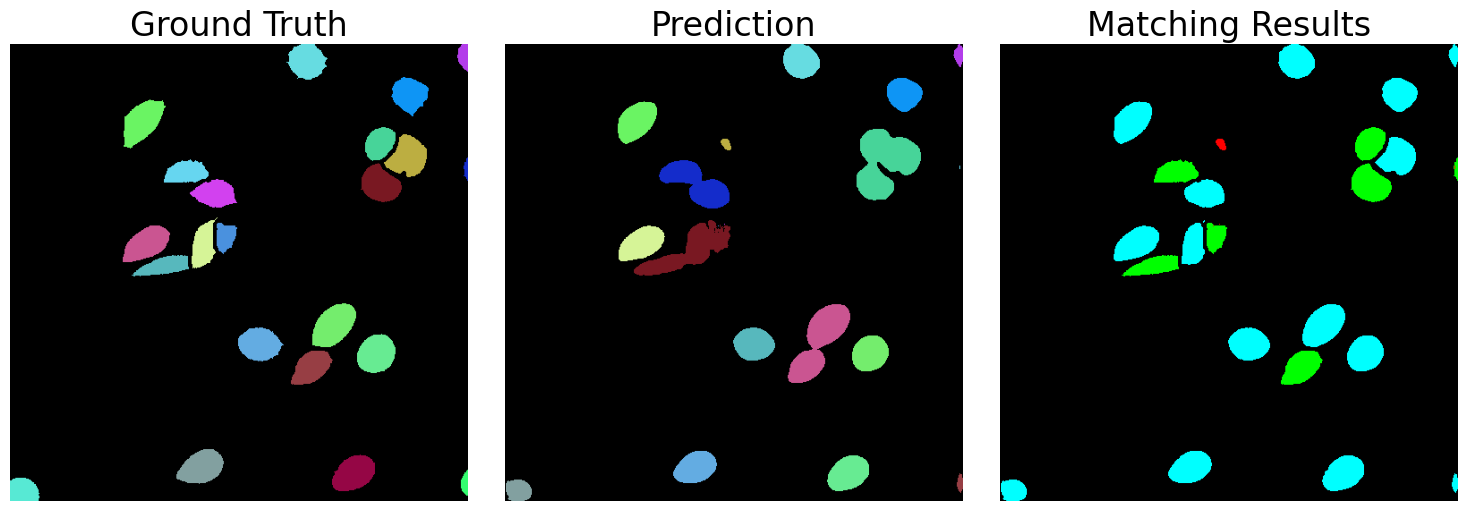

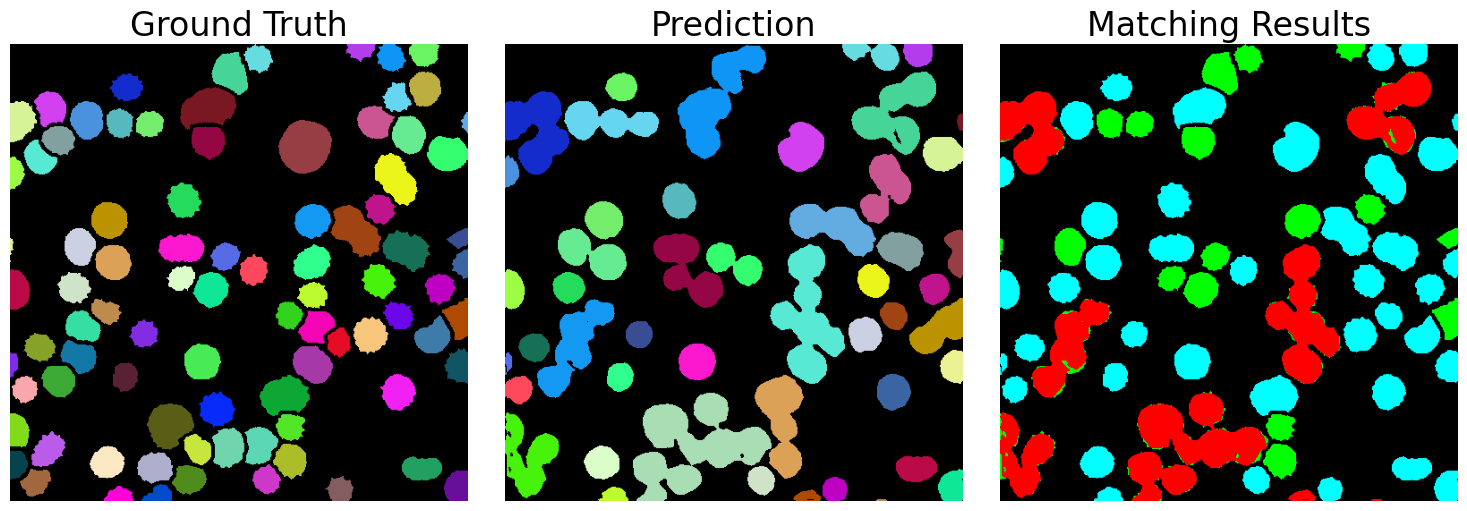

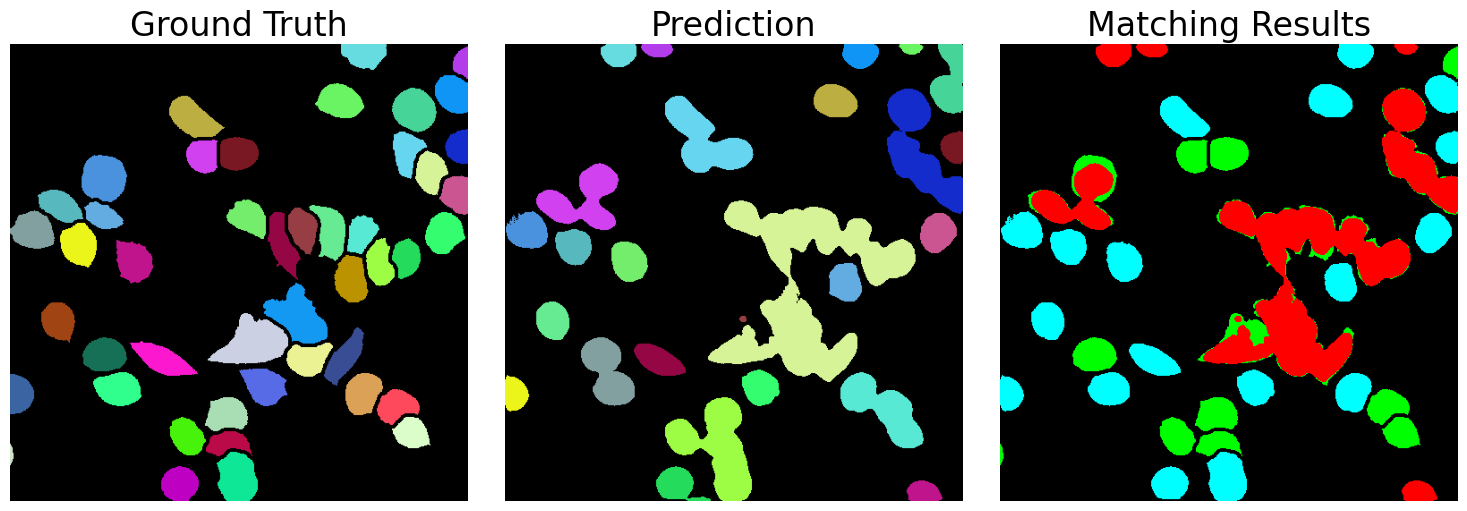

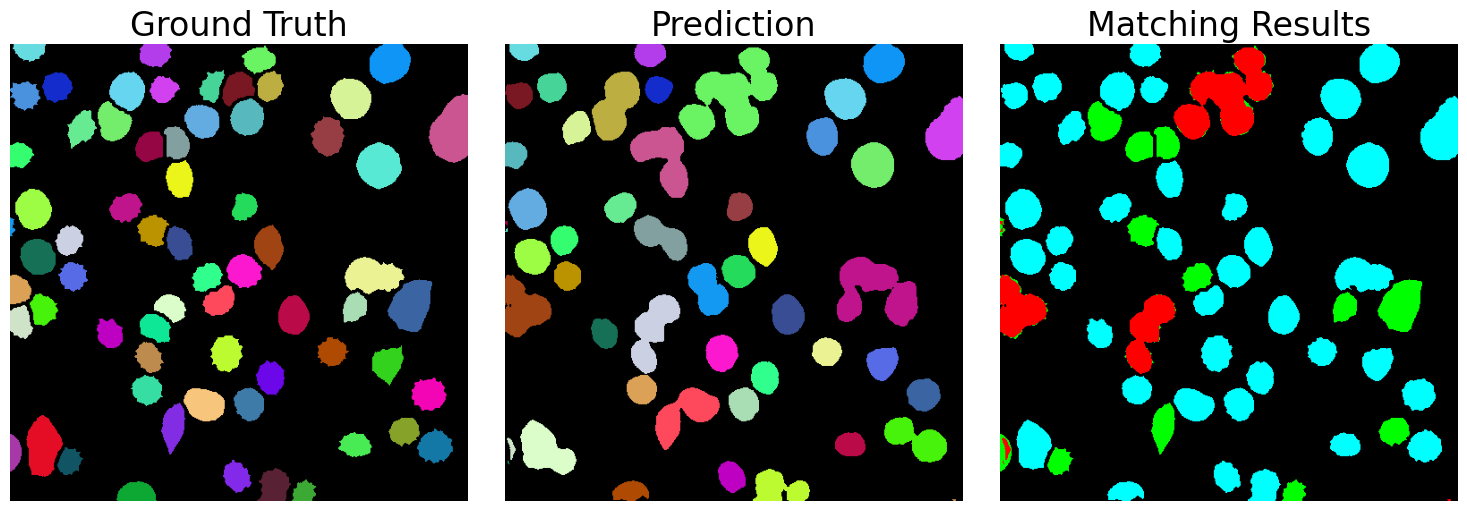

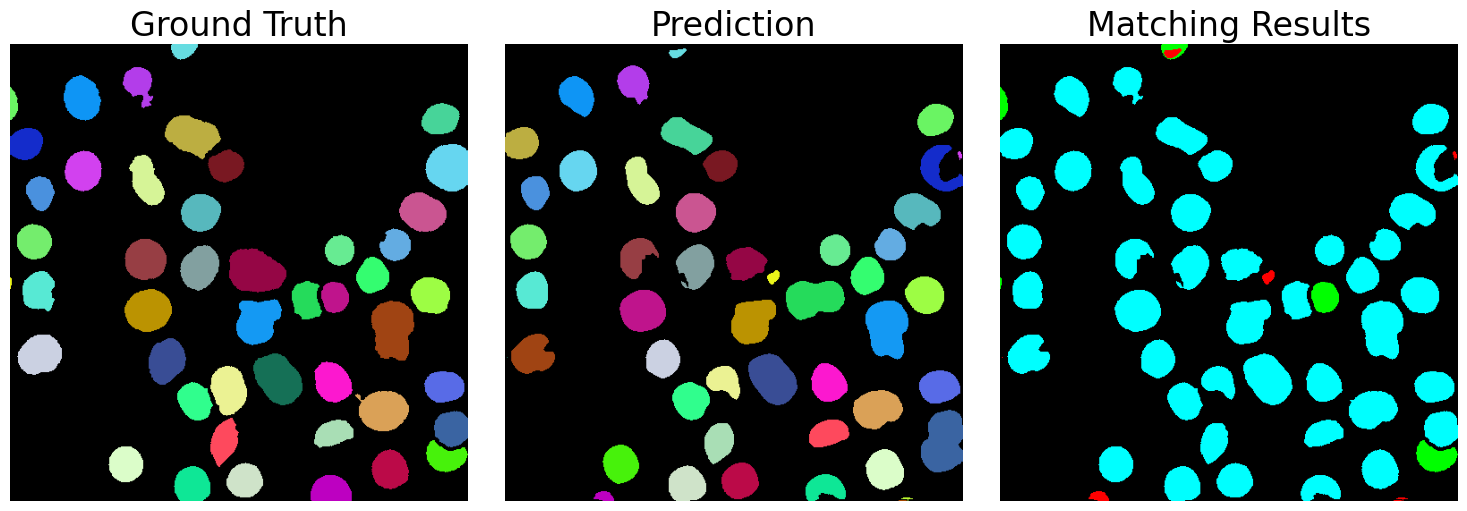

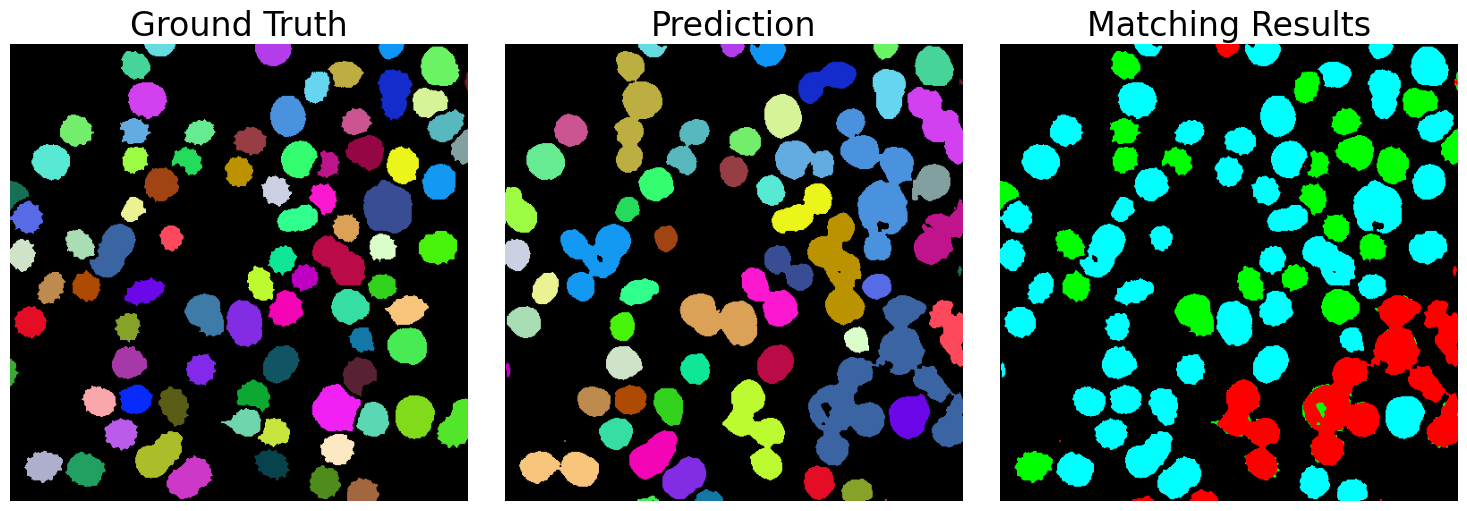

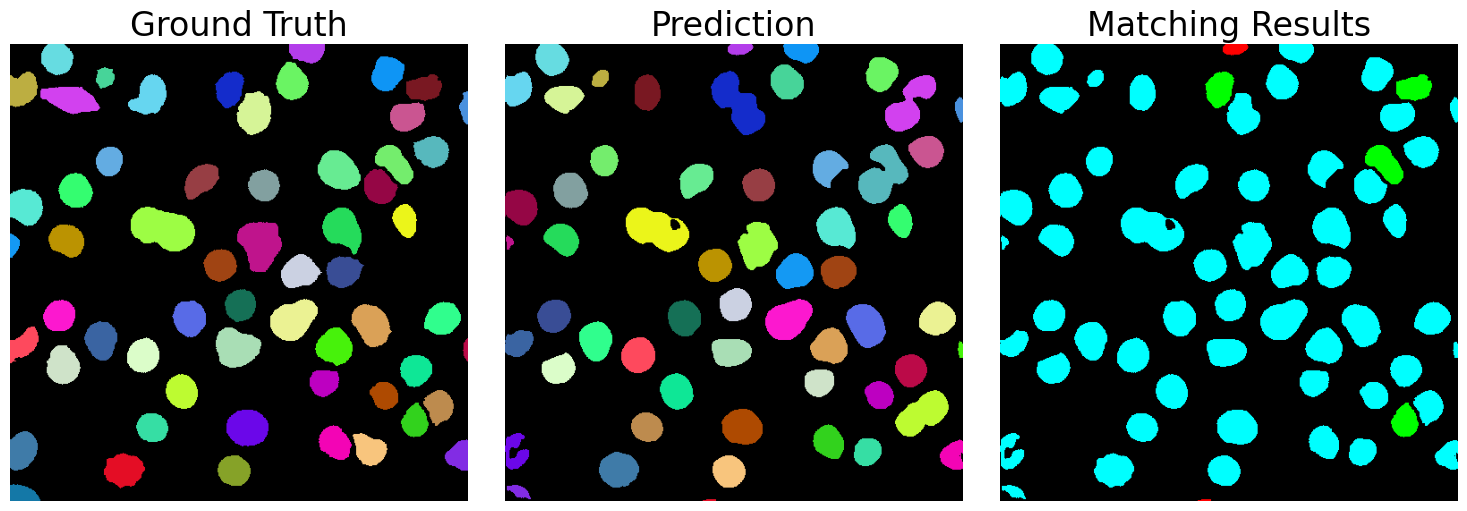

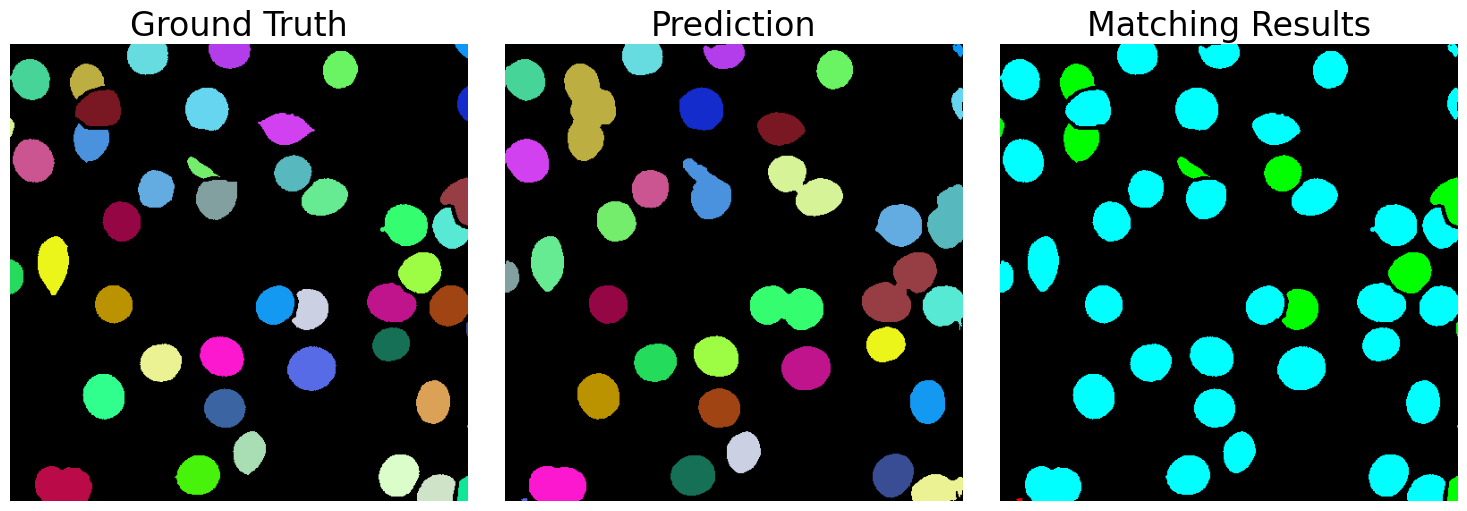

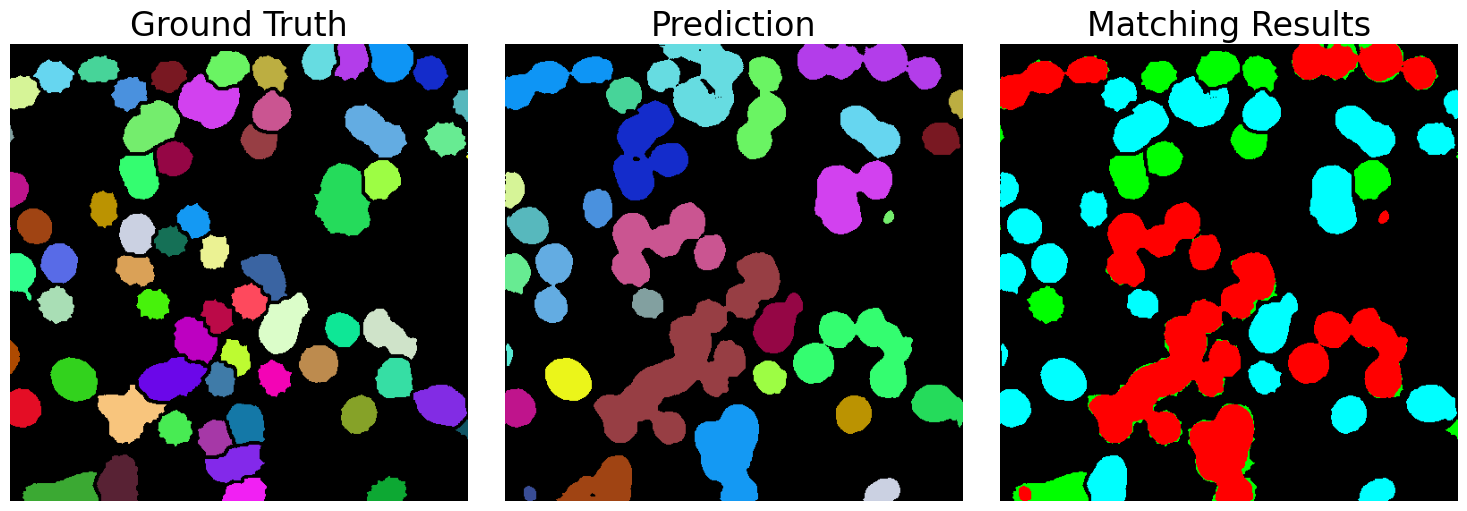

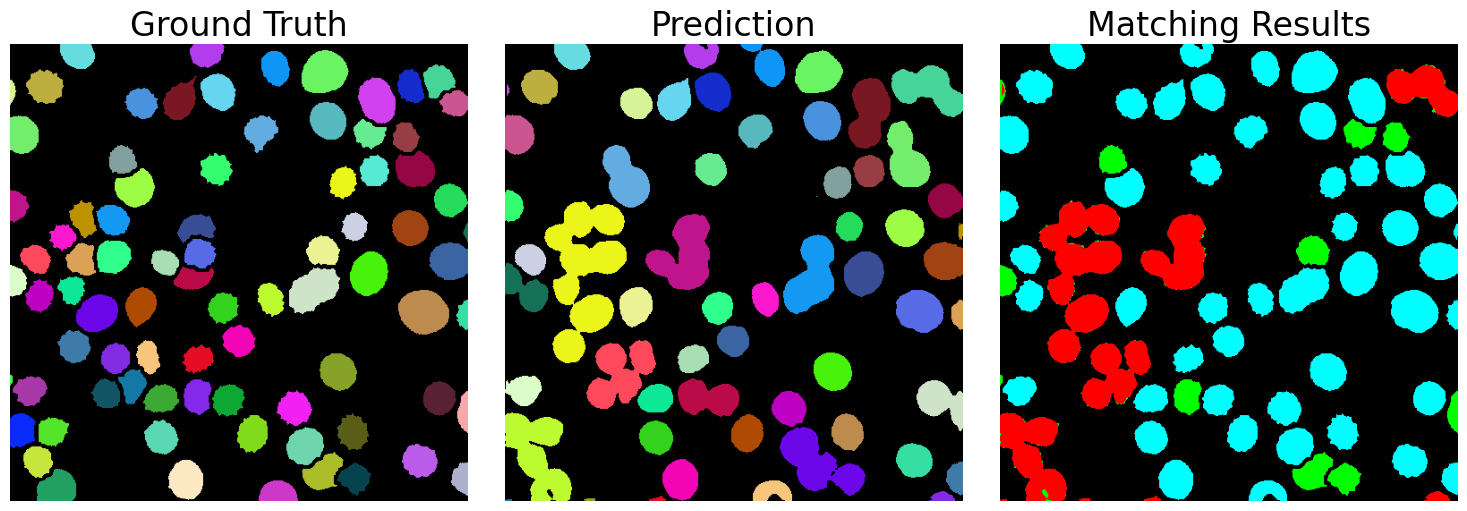

Average Precision: 0.8301
Average Recall: 0.6252
Average F1-Score: 0.7039


In [20]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import linear_sum_assignment

def label_and_color_image(image):
    """
    Label the connected components in the image and assign unique colors.
    """
    # Find the connected components
    num_labels, labeled_image = cv2.connectedComponents(image)
    
    # Generate random colors for each label
    np.random.seed(42)  
    colors = np.zeros((num_labels, 3), dtype=np.uint8) 

    # Assign colors
    for label in range(1, num_labels):
        while True:
            # Generate a random color
            color = np.random.randint(0, 255, size=(3,), dtype=np.uint8)
            # Exclude colors close to black
            brightness = 0.299 * color[0] + 0.587 * color[1] + 0.114 * color[2]
            if brightness > 50:  
                colors[label] = color
                break

    # Create image
    image_with_labels = np.zeros((image.shape[0], image.shape[1], 3), dtype=np.uint8)
    # Assign color to each component
    for label in range(1, num_labels):
        component = (labeled_image == label)
        image_with_labels[component] = colors[label]
    
    return labeled_image, image_with_labels, num_labels

def dice_coefficient(gt_mask, pred_mask):
    
    intersection = np.sum(gt_mask & pred_mask)
    dice = (2 * intersection) / (np.sum(gt_mask) + np.sum(pred_mask) + 1e-6)
    return dice

def match_cells_by_hungarian(gt_labeled, pred_labeled, dice_threshold=0.5):
    """
    Match ground truth cells and predicted cells using the Hungarian algorithm based on Dice coefficient.
    """
    
    gt_labels = np.unique(gt_labeled)[1:]# exclude background
    pred_labels = np.unique(pred_labeled)[1:]

    # Compute cost matrix with negative dice coefficeint
    cost_matrix = np.zeros((len(gt_labels), len(pred_labels)))
    for i, gt_id in enumerate(gt_labels):
        gt_mask = (gt_labeled == gt_id)
        for j, pred_id in enumerate(pred_labels):
            pred_mask = (pred_labeled == pred_id)
            cost_matrix[i, j] = -dice_coefficient(gt_mask, pred_mask)  
            
    # Apply Hungarian algorithm 
    row_ind, col_ind = linear_sum_assignment(cost_matrix)

    # Filter matches based on Dice coefficient threshold
    matches = []
    unmatched_gt = list(gt_labels)
    unmatched_pred = list(pred_labels)

    # Only dice > 0.5 => TP
    for i, j in zip(row_ind, col_ind):
        if -cost_matrix[i, j] > dice_threshold:  
            matches.append((gt_labels[i], pred_labels[j]))
            unmatched_gt.remove(gt_labels[i])
            unmatched_pred.remove(pred_labels[j])


    TP = len(matches)
    FP = len(unmatched_pred)
    FN = len(unmatched_gt)

    return matches, unmatched_gt, unmatched_pred, TP, FP, FN

def visualize_matching(gt_labeled, pred_labeled, gt_colored, pred_colored, matches, unmatched_gt, unmatched_pred):


    h, w = gt_labeled.shape
    combined_image = np.zeros((h, w, 3), dtype=np.uint8)
    match_color = (0, 255, 255)  # Yellow for matches
    gt_only_color = (0, 255, 0)  # Green for unmatched GT
    pred_only_color = (255, 0, 0)  # Red for unmatched Pred

    for gt_id, pred_id in matches:
        gt_mask = (gt_labeled == gt_id)
        pred_mask = (pred_labeled == pred_id)
        combined_image[gt_mask & pred_mask] = match_color
  
    for gt_id in unmatched_gt:
        gt_mask = (gt_labeled == gt_id)
        combined_image[gt_mask] = gt_only_color
   
    for pred_id in unmatched_pred:
        pred_mask = (pred_labeled == pred_id)
        combined_image[pred_mask] = pred_only_color

    
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 3, 1)
    plt.title("Ground Truth", fontsize=24)
    plt.imshow(gt_colored)
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.title("Prediction", fontsize=24)
    plt.imshow(pred_colored)
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.title("Matching Results",  fontsize=24)
    plt.imshow(combined_image)
    plt.axis("off")

    plt.tight_layout()
    plt.show()

def process_folder_with_hungarian_matching(pred_folder, gt_folder, dice_threshold=0.5):
    """
    Process matching and calculate average precision, recall, and F1-score.
    """
    gt_files = sorted(os.listdir(gt_folder))
    pred_files = sorted(os.listdir(pred_folder))

    precision_list = []
    recall_list = []
    f1_list = []

    for gt_file, pred_file in zip(gt_files, pred_files):
        gt_image = cv2.imread(os.path.join(gt_folder, gt_file), cv2.IMREAD_GRAYSCALE)
        pred_file = f"pred_{gt_file}"
        pred_image = cv2.imread(os.path.join(pred_folder, pred_file), cv2.IMREAD_GRAYSCALE)
        
        if gt_image is None or pred_image is None:
            print('Image is None.')
            continue

        # Label and color the GT and Prediction images
        gt_labeled, gt_colored, num_gt_labels = label_and_color_image(gt_image)
        pred_labeled, pred_colored, num_pred_labels = label_and_color_image(pred_image)
        # Perform Hungarian matching
        matches, unmatched_gt, unmatched_pred, TP, FP, FN = match_cells_by_hungarian(gt_labeled, pred_labeled, dice_threshold)
        # Present matching result
        visualize_matching(gt_labeled, pred_labeled, gt_colored, pred_colored, matches, unmatched_gt, unmatched_pred)
        
        # Calculate per-slide metrics
        precision = TP / (TP + FP + 1e-6)
        recall = TP / (TP + FN + 1e-6)
        f1_score = 2 * (precision * recall) / (precision + recall + 1e-6)

        precision_list.append(precision)
        recall_list.append(recall)
        f1_list.append(f1_score)

    # Calculate average metrics across slides
    avg_precision = np.mean(precision_list)
    avg_recall = np.mean(recall_list)
    avg_f1 = np.mean(f1_list)

    return avg_precision, avg_recall, avg_f1


pred_folder = "./unet_outputs"
gt_folder = "data/test_tmp/eroded_mask"
avg_precision, avg_recall, avg_f1 = process_folder_with_hungarian_matching(pred_folder, gt_folder)
print(f'Average Precision: {avg_precision:.4f}')
print(f'Average Recall: {avg_recall:.4f}')
print(f'Average F1-Score: {avg_f1:.4f}')

